In [107]:
import numpy as np
import math
from math import comb
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Environment parameters
K = 30  # Number of content items
u_min = 0.1  # Threshold for content relevance
C = int(0.2 * K)  # Number of cached items
#C = 2
# User model parameters
N = 2 # Number of recommended items
q = 0.2  # Probability of ending the viewing session
alpha = 0.8  # Probability of selecting a recommended item
#tradeoff_factor=0.4
# Generate random relevance values
U = np.random.rand(K, K)
np.fill_diagonal(U, 0)  # Set diagonal elements to 0
# U = np.array([[0., 0.09709217, 0.95697935, 0.76421269, 0.79379138],
#               [0.85679266, 0., 0.73115609, 0.97025111, 0.00706508],
#               [0.38327773, 0.27582305, 0., 0.40938946, 0.70918518],
#               [0.27415892, 0.89691232, 0.47103534, 0., 0.97776446],
#               [0.06699551, 0.96500574, 0.00547615, 0.74654658, 0.]])
# U = np.array([[0.0, 0.8, 0.3, 0.6],
#               [0.8, 0.0, 0.7, 0.2],
#               [0.3, 0.1, 0.0, 0.2],
#               [0.6, 0.4, 0.2, 0.0]])
print(U)
#vector to denote the cost of each state. 1 for non-cached, 0 for cached
Cost = [1]*(K-C) +[0]*C   
#Cost = [1,0,1,0]
random.shuffle(Cost)
print(Cost)

Tmax = 10000

#create action set as the set of every possible combination of N=2 states 
action_set = []
for i in range(K):
    for j in range(i+1,K):
        a = (i, j)
        action_set.append(a)

num_of_actions = len(action_set)

action_table = [[] for _ in range(K)]

for i in range(K):
    for a in action_set:
        if i not in a:
            action_table[i].append(a)
num_of_actions = len(action_table[0])
#num_of_actions = comb(K,N)

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 1-q
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
epsilon = 1
TAU = 0.005
LR = 1e-4
losses = []
# Get number of actions from gym action space

# Get the number of state observations




[[0.         0.14105844 0.80344677 0.10654971 0.69898189 0.59250283
  0.836605   0.38924671 0.3197131  0.62294118 0.7410001  0.26904295
  0.27502356 0.18557188 0.75915386 0.27757181 0.48581155 0.41166141
  0.90995414 0.96552933 0.23544656 0.53677198 0.99504238 0.25172848
  0.64420341 0.39075873 0.86015719 0.32440071 0.68169402 0.90432759]
 [0.4233353  0.         0.82773111 0.09183031 0.55405255 0.60855822
  0.84128157 0.33279455 0.81722318 0.02733318 0.78557677 0.81286961
  0.34338902 0.48993953 0.87516752 0.34643272 0.99880239 0.24217258
  0.60157979 0.40513377 0.16153818 0.08548157 0.26863996 0.60401125
  0.53330663 0.00670251 0.71469387 0.45499802 0.65157768 0.41646026]
 [0.85752493 0.79584872 0.         0.02685153 0.6951626  0.6657965
  0.00320696 0.50645474 0.26049407 0.34874638 0.40387822 0.88155881
  0.00822066 0.21593821 0.68119124 0.56010073 0.03790608 0.87883019
  0.64301617 0.53672949 0.27773016 0.43268543 0.68381307 0.78096878
  0.6716704  0.64757854 0.13172133 0.04804958 0

## Replay Memory

In [108]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DNN

In [109]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 512)
        self.layer5 = nn.Linear(512, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        #print("xxxx")
        #print(self.layer5(x))
        return self.layer5(x)

## Optimizer

In [110]:
policy_net = DQN(K, num_of_actions).to(device)
target_net = DQN(K, num_of_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

def optimize_model(terminated):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    #print(batch)
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
    #                                       batch.next_state)), device=device, dtype=torch.bool)
    # non_final_next_states = torch.cat([s for s in batch.next_state
    #                                             if s is not None])
    state_batch = torch.cat(batch.state)
    #print(f"state batch {state_batch.view(64, 1)}")
    action_batch = torch.cat(batch.action)
    #print(f"action batch {action_batch}")
    reward_batch = torch.cat(batch.reward)
    #print(f"reward batch {reward_batch}")
    next_state_batch = torch.cat(batch.next_state)
    #print(f"ns batch {next_state_batch}")
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    Q = policy_net(10*state_batch).gather(1, action_batch.view(BATCH_SIZE, 1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    if (not terminated):
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            V_s_prime = target_net(10*next_state_batch).max(1)[0]
        # Compute the expected Q values
        target = (V_s_prime * GAMMA) + reward_batch
    else:
        target = reward_batch
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    #print(f"Q {Q}")
    #print(f"target {target}")
    loss = criterion(Q, target.unsqueeze(1))
    losses.append(loss.item())
   # print(loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    print(loss)

## DQN

0
1
2
3
4
5
6


C:\Users\thodoris\AppData\Local\Temp\ipykernel_14444\2905214864.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_idx = torch.tensor(a_idx, dtype=torch.int64, device=device).unsqueeze(0)


7
8
9
10
11
12
13
14
15
16
17
18
19
20
tensor(0.9715, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9537, grad_fn=<SmoothL1LossBackward0>)
21
tensor(0.9516, grad_fn=<SmoothL1LossBackward0>)
22
tensor(0.9183, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9104, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9397, grad_fn=<SmoothL1LossBackward0>)
tensor(0.8919, grad_fn=<SmoothL1LossBackward0>)
23
tensor(0.9259, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9248, grad_fn=<SmoothL1LossBackward0>)
tensor(0.8340, grad_fn=<SmoothL1LossBackward0>)
24
tensor(0.9493, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9053, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9313, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9248, grad_fn=<SmoothL1LossBackward0>)
tensor(0.8862, grad_fn=<SmoothL1LossBackward0>)
tensor(0.7790, grad_fn=<SmoothL1LossBackward0>)
tensor(0.8735, grad_fn=<SmoothL1LossBackward0>)
tensor(0.8565, grad_fn=<SmoothL1LossBackward0>)
25
tensor(0.8904, grad_fn=<SmoothL1LossBackward0>)
tensor(0.9188, grad_fn=<SmoothL1Lo

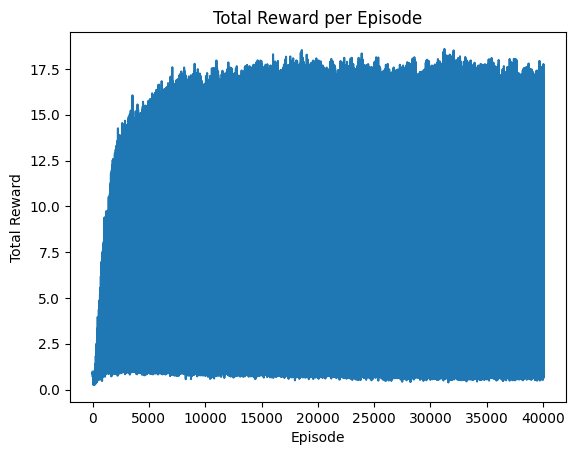

[[10 14]
 [13 29]
 [ 9 13]
 [13 29]
 [13 29]
 [ 9 12]
 [ 9 13]
 [ 9 11]
 [10 13]
 [13 29]
 [ 8 12]
 [13 29]
 [13 29]
 [ 9 12]
 [ 9 12]
 [ 9 12]
 [12 29]
 [ 8 10]
 [ 9 12]
 [12 29]
 [ 9 12]
 [ 9 12]
 [12 13]
 [12 29]
 [12 29]
 [12 29]
 [ 8 11]
 [12 29]
 [12 13]
 [ 9 12]]


In [111]:

steps_done = 0

def k_to_combination(point,k, N, K, offset):
   
    if(N == 1):
        point.append(k+offset)
        return point
    lower = 1
    upper = comb(K-1,N-1)
    i=0
    
    while k+1 > upper:
        i += 1
        lower = upper + 1
        upper = upper + comb(K-1-i,N-1)
    # if(i+offset == state):
    #     offset+=1
    point.append(i+offset)
    #print(point)
    return k_to_combination(point,k-lower+1,N-1,K-i-1,i+offset+1)


def select_action(s,s_tensor):
    global steps_done, epsilon
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net.layer3)
            #state = torch.FloatTensor(state)
            #print(state)
            #print(policy_net(s_tensor).view(num_of_actions,))
            action=policy_net(10*s_tensor).view(num_of_actions,).max(0)[1]
            
    else:
        # while True:
            action = np.random.randint(num_of_actions)
            # if(int(state.item()) not in k_to_combination([],action,N,K,0)):
            #     break
    #epsilon = (steps_done+1)**(-1/3)*(num_of_actions*math.log(steps_done+1))**(1/3)

    #return action,torch.tensor(k_to_combination([],action,N,K,0), device=device)
    #print(f"s {s} action {action}")
    return action,action_table[s][action]


episode_durations = []

def all_recommendations_are_relevant(recommendations,s):
    """
    function to check whether everey recommended state in the racommendation batch is 
    relevant to s

    arguments:
    recommendations (tuple of ints): recommendation batch for state s
    s (int): current state

    returns:
    True: if all recommendation are relevant to s
    False: otherwise
    """
    for u in recommendations:
       # print(f"u: {u}")
        #print(f"s: {s}")
        if U[s][int(u)]<u_min:
            return False
    return True


if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 8000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    print(i_episode)
    s = np.random.randint(K) #random initial stat
    #print(s)
    s_tensor = torch.tensor(U[s], dtype=torch.float32, device=device).unsqueeze(0)
    #print(s)
    #print(int(s.item()))
    for t in count():
        a_idx,a = select_action(s,s_tensor)
        #print(f"action {a}")
        if (all_recommendations_are_relevant(a,int(s))):
            
            #if np.random.uniform() < alpha:  # If all recommended items are relevant
            s_prime = int(np.random.choice(a))  # Pick a random item from relevant recommended items
            #else:  # If at least one recommended item is not relevant
            #    s_prime = np.random.randint(K)  # Pick a random item
            reward = (1 - Cost[s_prime])*5
        else:
            s_prime = np.random.randint(K)  # Pick a random item
        # if(int(s.item()) in k_to_combination([],a_idx,N,K,0)):
            reward =-1
        # else:
        

        a_idx = torch.tensor(a_idx, dtype=torch.int64, device=device).unsqueeze(0)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0) 
        s_prime_tensor = torch.tensor(U[s_prime], dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(s_tensor, a_idx, s_prime_tensor, reward)



        if np.random.uniform() < q:
            terminated = True
        else:
            terminated = False
        # Perform one step of the optimization (on the policy network)
        optimize_model(terminated)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated:
            break
        
        # Move to the next state
        s = s_prime
# print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show() 
plt.plot(range(steps_done-BATCH_SIZE+1), losses)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show() 

pi_Q_learning  =  np.zeros((K, N), dtype=np.int16)
for s in range(K):
    #Q[s][s] = float('-inf')
    s_t= torch.tensor(U[s], dtype=torch.float32, device=device).unsqueeze(0)
    action = policy_net(10*s_t).view(num_of_actions,).max(0)[1]
    #pi_Q_learning[s] = k_to_combination([],action,N,K,0)
    pi_Q_learning[s] = action_table[s][action]
print(pi_Q_learning)

In [112]:
def simulate_session(policy, max_steps=1000):
    """
    Simulate a viewing session following a given policy

    arguments:
    policy to be simulated

    returns:
    total cost of the session
    
    """
    s = np.random.randint(K)  # random initial
    cost_total = Cost[s]  
    for _ in range(max_steps):
        if np.random.uniform() < q:  # The user decides to quit
            break
        #print(s)
        #print(policy[s])
        if (all_recommendations_are_relevant(policy[s],s)):
            
            if np.random.uniform() < alpha:  # If all recommended items are relevant
                s_prime = int(np.random.choice(policy[s]))  # Pick a random item from relevant recommended items
            else:  # If at least one recommended item is not relevant
                s_prime = np.random.randint(K)  # Pick a random item
        else:
            s_prime = np.random.randint(K)  # Pick a random item
        
        s=s_prime
        cost_total += Cost[s]  # Add the cost of the picked item
    return cost_total

def simulation(policy):
    """
    function to run multiple sessions
    """
    total_cost = 0
    num_of_episodes=50000
    for _ in range(num_of_episodes):
        total_cost  += simulate_session(policy)

    print(total_cost/num_of_episodes)

print(U)
print(Cost)
#print(P_opt1)
print(pi_Q_learning)

print("average cost for Policy iteration:")
#simulation(P_opt1)
#simulation(P_opt2)
print("average cost for Q Learning:")
simulation(pi_Q_learning)

[[0.         0.14105844 0.80344677 0.10654971 0.69898189 0.59250283
  0.836605   0.38924671 0.3197131  0.62294118 0.7410001  0.26904295
  0.27502356 0.18557188 0.75915386 0.27757181 0.48581155 0.41166141
  0.90995414 0.96552933 0.23544656 0.53677198 0.99504238 0.25172848
  0.64420341 0.39075873 0.86015719 0.32440071 0.68169402 0.90432759]
 [0.4233353  0.         0.82773111 0.09183031 0.55405255 0.60855822
  0.84128157 0.33279455 0.81722318 0.02733318 0.78557677 0.81286961
  0.34338902 0.48993953 0.87516752 0.34643272 0.99880239 0.24217258
  0.60157979 0.40513377 0.16153818 0.08548157 0.26863996 0.60401125
  0.53330663 0.00670251 0.71469387 0.45499802 0.65157768 0.41646026]
 [0.85752493 0.79584872 0.         0.02685153 0.6951626  0.6657965
  0.00320696 0.50645474 0.26049407 0.34874638 0.40387822 0.88155881
  0.00822066 0.21593821 0.68119124 0.56010073 0.03790608 0.87883019
  0.64301617 0.53672949 0.27773016 0.43268543 0.68381307 0.78096878
  0.6716704  0.64757854 0.13172133 0.04804958 0